In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
df = pd.read_csv('german_credit_data.csv')

print(f"Loaded {len(df)} loan applications")
print(df.head())

Loaded 1000 loan applications
   laufkont  laufzeit  moral  verw  hoehe  sparkont  beszeit  rate  famges  \
0         1        18      4     2   1049         1        2     4       2   
1         1         9      4     0   2799         1        3     2       3   
2         2        12      2     9    841         2        4     2       2   
3         1        12      4     0   2122         1        3     3       3   
4         1        12      4     0   2171         1        3     4       3   

   buerge  ...  verm  alter  weitkred  wohn  bishkred  beruf  pers  telef  \
0       1  ...     2     21         3     1         1      3     2      1   
1       1  ...     1     36         3     1         2      3     1      1   
2       1  ...     1     23         3     1         1      2     2      1   
3       1  ...     1     39         3     1         2      2     1      1   
4       1  ...     2     38         1     2         2      2     2      1   

   gastarb  kredit  
0        2       

In [3]:
# Create simpler column names
df['Age'] = df['alter']
df['CreditAmount'] = df['hoehe']
df['Duration'] = df['laufzeit']

# Create target variable: 1=Approved, 0=Rejected
# In the data: kredit 1=Good (Approved), kredit 2=Bad (Rejected)
df['Approved'] = df['kredit'].apply(lambda x: 1 if x == 1 else 0)

# Extract Gender from 'famges' (PersonalStatus)
# 1,3,4 = Male | 2,5 = Female
df['Gender'] = df['famges'].apply(lambda x: 'Male' if x in [1,3,4] else 'Female')

# Create Age Groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100], 
                         labels=['Under 25', '25-35', '35-50', 'Over 50'])

print(f"\nData prepared!")
print(f"Total approved: {df['Approved'].sum()} ({df['Approved'].mean()*100:.1f}%)")
print(f"\nGender breakdown:")
print(df['Gender'].value_counts())


Data prepared!
Total approved: 700 (70.0%)

Gender breakdown:
Gender
Male      690
Female    310
Name: count, dtype: int64



 Saved: overview.png


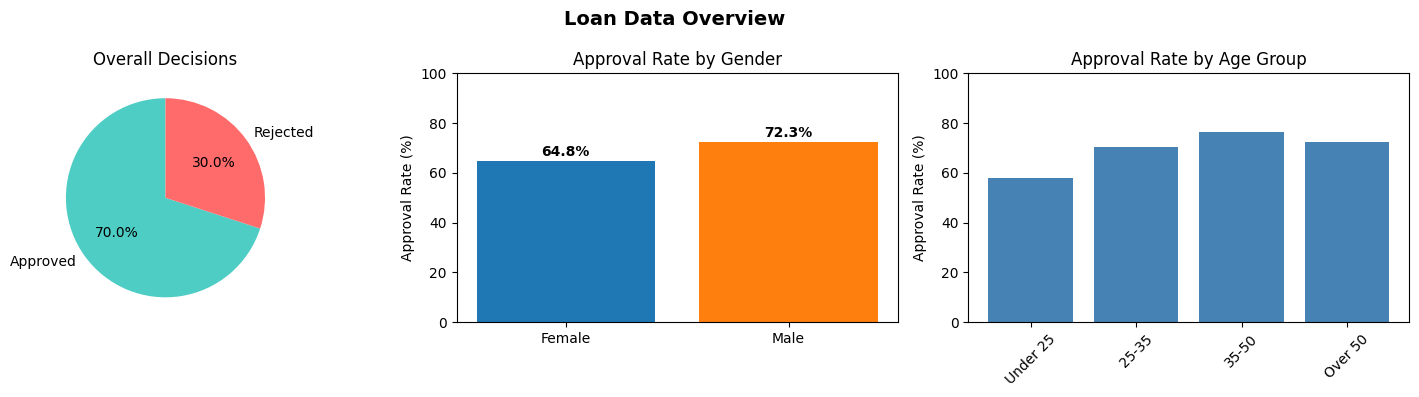

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Loan Data Overview', fontsize=14, fontweight='bold')

# Plot 1: Overall approval
approval_counts = df['Approved'].value_counts()
axes[0].pie(approval_counts, labels=['Approved', 'Rejected'], autopct='%1.1f%%', 
           colors=['#4ecdc4', '#ff6b6b'], startangle=90)
axes[0].set_title('Overall Decisions')

# Plot 2: Approval by Gender
gender_approval = df.groupby('Gender')['Approved'].mean() * 100
axes[1].bar(gender_approval.index, gender_approval.values, color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('Approval Rate (%)')
axes[1].set_title('Approval Rate by Gender')
axes[1].set_ylim(0, 100)
for i, v in enumerate(gender_approval.values):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 3: Approval by Age
age_approval = df.groupby('AgeGroup')['Approved'].mean() * 100
axes[2].bar(range(len(age_approval)), age_approval.values, color='steelblue')
axes[2].set_xticks(range(len(age_approval)))
axes[2].set_xticklabels(age_approval.index, rotation=45)
axes[2].set_ylabel('Approval Rate (%)')
axes[2].set_title('Approval Rate by Age Group')
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('overview.png', dpi=300)
print("\n Saved: overview.png")
plt.show()

In [5]:
# Select features for the model
features = ['alter', 'hoehe', 'laufzeit', 'rate', 'famges', 'sparkont', 'beszeit']
X = df[features]
y = df['Approved']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"\n Model trained!")
print(f"Accuracy: {accuracy*100:.1f}%")

# Add predictions to test data
test_data = df.loc[X_test.index].copy()
test_data['Predicted'] = y_pred


 Model trained!
Accuracy: 73.5%


In [6]:
print("FAIRNESS AUDIT - 80% RULE TEST")
def check_fairness(data, group_column):
    """
    Check if model is fair using the 80% Rule
    Formula: (Lowest approval rate) / (Highest approval rate) >= 0.80
    """
    # Calculate approval rates for each group
    approval_rates = data.groupby(group_column)['Predicted'].mean()
    
    # Find highest and lowest
    highest_rate = approval_rates.max()
    lowest_rate = approval_rates.min()
    
    # Calculate ratio
    ratio = lowest_rate / highest_rate
    
    # Check if passes
    passes = ratio >= 0.80
    
    print(f"\n{group_column.upper()} FAIRNESS:")
    print("-" * 50)
    for group in approval_rates.index:
        rate = approval_rates[group]
        print(f"  {group}: {rate*100:.1f}% approval rate")
    
    print(f"\n  Fairness Ratio: {ratio:.3f}")
    if passes:
        print(f"  Result: PASS (ratio >= 0.80)")
    else:
        print(f"  Result: FAIL (ratio < 0.80)")
        print(f"    This is DISCRIMINATION!")
    
    return ratio, passes

# Test Gender Fairness
gender_ratio, gender_pass = check_fairness(test_data, 'Gender')

# Test Age Fairness
age_ratio, age_pass = check_fairness(test_data, 'AgeGroup')


FAIRNESS AUDIT - 80% RULE TEST

GENDER FAIRNESS:
--------------------------------------------------
  Female: 75.8% approval rate
  Male: 90.3% approval rate

  Fairness Ratio: 0.839
  Result: PASS (ratio >= 0.80)

AGEGROUP FAIRNESS:
--------------------------------------------------
  Under 25: 77.8% approval rate
  25-35: 84.3% approval rate
  35-50: 90.7% approval rate
  Over 50: 88.9% approval rate

  Fairness Ratio: 0.857
  Result: PASS (ratio >= 0.80)



 Saved: fairness_results.png


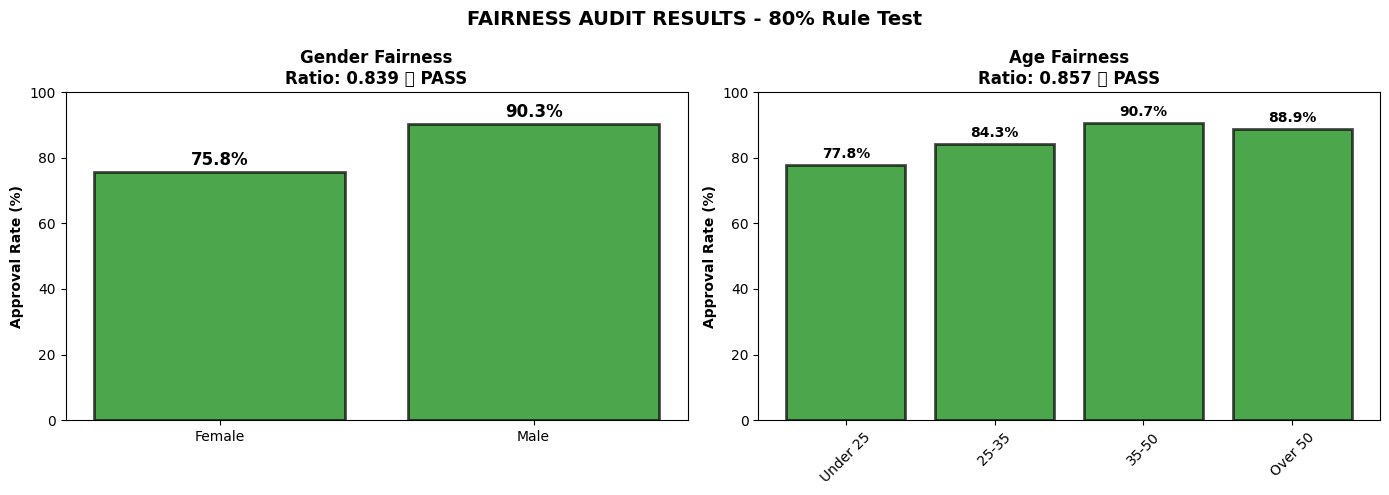

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('FAIRNESS AUDIT RESULTS - 80% Rule Test', fontsize=14, fontweight='bold')

# Gender chart
gender_approval = test_data.groupby('Gender')['Predicted'].mean() * 100
colors = ['green' if gender_pass else 'red', 'green' if gender_pass else 'red']
bars = axes[0].bar(gender_approval.index, gender_approval.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Approval Rate (%)', fontweight='bold')
axes[0].set_title(f'Gender Fairness\nRatio: {gender_ratio:.3f} {"✅ PASS" if gender_pass else "❌ FAIL"}', fontweight='bold')
axes[0].set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', fontweight='bold', fontsize=12)

# Age chart
age_approval = test_data.groupby('AgeGroup')['Predicted'].mean() * 100
colors = ['green' if age_pass else 'red'] * len(age_approval)
bars = axes[1].bar(range(len(age_approval)), age_approval.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(age_approval)))
axes[1].set_xticklabels(age_approval.index, rotation=45)
axes[1].set_ylabel('Approval Rate (%)', fontweight='bold')
axes[1].set_title(f'Age Fairness\nRatio: {age_ratio:.3f} {"✅ PASS" if age_pass else "❌ FAIL"}', fontweight='bold')
axes[1].set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('fairness_results.png', dpi=300)
print("\n Saved: fairness_results.png")
plt.show()

In [8]:
print("SECURITY TEST - MODEL STABILITY")

print("\n Testing: Can applicants game the system by changing their data slightly?")

# Take 20 rejected applications
rejected = test_data[test_data['Predicted'] == 0].head(20)

flip_counts = {}

for feature in features:
    flips = 0
    
    for idx in rejected.index:
        original = X_test.loc[idx]
        
        # Change feature by just 1%
        modified = original.copy()
        modified[feature] = original[feature] * 1.05
        
        # Check if decision changes
        new_prediction = model.predict([modified.values])[0]
        
        if new_prediction == 1:  # Rejection changed to approval!
            flips += 1
    
    flip_rate = (flips / len(rejected)) * 100
    flip_counts[feature] = flip_rate

# Show results
print("\nIf someone changes each feature by 1%, how often does rejection become approval?")

for feature, rate in sorted(flip_counts.items(), key=lambda x: x[1], reverse=True):
    if rate > 5:
        risk = "🔴 HIGH RISK"
    elif rate > 2:
        risk = "🟡 MEDIUM RISK"
    else:
        risk = "🟢 LOW RISK"
    print(f"  {feature}: {rate:.1f}% flip rate - {risk}")

# Find most vulnerable
most_vulnerable = max(flip_counts, key=flip_counts.get)
print(f"\n  Most vulnerable feature: {most_vulnerable} ({flip_counts[most_vulnerable]:.1f}% flip rate)")

if flip_counts[most_vulnerable] > 10:
    print(f"  SECURITY RISK: People can manipulate {most_vulnerable} to get approved!")


SECURITY TEST - MODEL STABILITY

 Testing: Can applicants game the system by changing their data slightly?

If someone changes each feature by 1%, how often does rejection become approval?
  alter: 20.0% flip rate - 🔴 HIGH RISK
  hoehe: 10.0% flip rate - 🔴 HIGH RISK
  laufzeit: 0.0% flip rate - 🟢 LOW RISK
  rate: 0.0% flip rate - 🟢 LOW RISK
  famges: 0.0% flip rate - 🟢 LOW RISK
  sparkont: 0.0% flip rate - 🟢 LOW RISK
  beszeit: 0.0% flip rate - 🟢 LOW RISK

  Most vulnerable feature: alter (20.0% flip rate)
  SECURITY RISK: People can manipulate alter to get approved!



 Saved: security_results.png


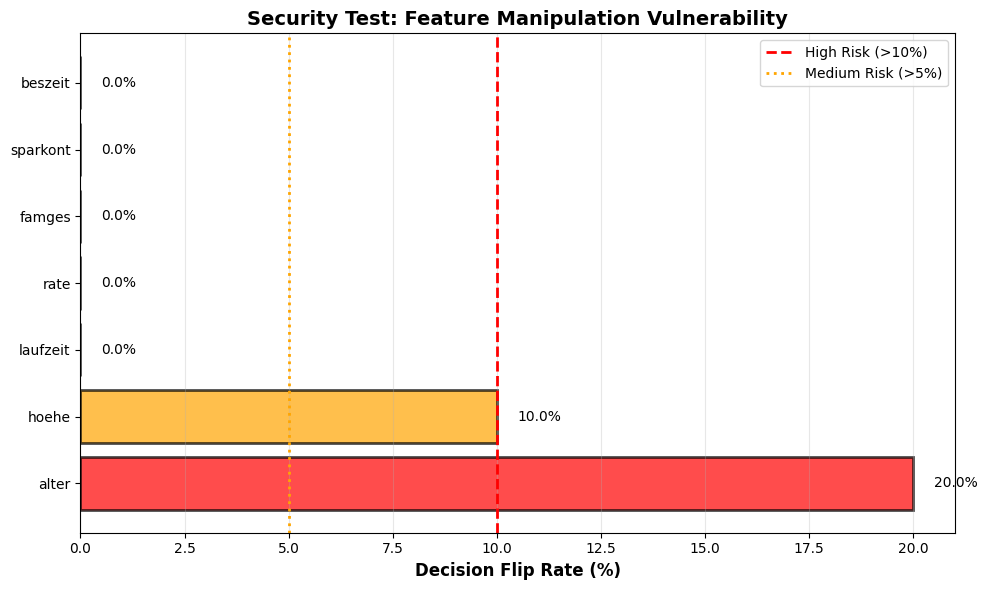

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Sort and plot
sorted_features = sorted(flip_counts.items(), key=lambda x: x[1], reverse=True)
features_list = [f[0] for f in sorted_features]
rates_list = [f[1] for f in sorted_features]

colors = ['red' if r > 10 else 'orange' if r > 5 else 'green' for r in rates_list]

bars = ax.barh(features_list, rates_list, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.axvline(x=10, color='red', linestyle='--', linewidth=2, label='High Risk (>10%)')
ax.axvline(x=5, color='orange', linestyle=':', linewidth=2, label='Medium Risk (>5%)')
ax.set_xlabel('Decision Flip Rate (%)', fontweight='bold', fontsize=12)
ax.set_title('Security Test: Feature Manipulation Vulnerability', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
           f'{width:.1f}%', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('security_results.png', dpi=300)
print("\n Saved: security_results.png")
plt.show()


In [10]:
print("FINAL AUDIT SUMMARY")

# Determine overall risk
fairness_issues = 0
if not gender_pass:
    fairness_issues += 1
if not age_pass:
    fairness_issues += 1

security_issues = 0
if flip_counts[most_vulnerable] > 10:
    security_issues += 1

total_issues = fairness_issues + security_issues

if total_issues >= 2:
    risk_level = "🔴 HIGH RISK"
elif total_issues == 1:
    risk_level = "🟡 MEDIUM RISK"
else:
    risk_level = "🟢 LOW RISK"

print(f"\nOVERALL RISK LEVEL: {risk_level}")


print(f"\n FAIRNESS FINDINGS:")
if not gender_pass:
    print(f"    Gender bias detected (ratio: {gender_ratio:.3f})")
else:
    print(f"   No gender bias")

if not age_pass:
    print(f"   Age bias detected (ratio: {age_ratio:.3f})")
else:
    print(f"   No age bias")

print(f"\n SECURITY FINDINGS:")
if security_issues > 0:
    print(f"   Model can be manipulated via {most_vulnerable}")
else:
    print(f"   Model is reasonably secure")

print(f"\n RECOMMENDATIONS:")
if fairness_issues > 0:
    print(f"   1. Retrain model to remove bias")
    print(f"   2. Add human review for affected groups")

if security_issues > 0:
    print(f"   3. Add limits on how much {most_vulnerable} can change")
    print(f"   4. Monitor for suspicious patterns")

print(" AUDIT COMPLETE!")


FINAL AUDIT SUMMARY

OVERALL RISK LEVEL: 🟡 MEDIUM RISK

 FAIRNESS FINDINGS:
   No gender bias
   No age bias

 SECURITY FINDINGS:
   Model can be manipulated via alter

 RECOMMENDATIONS:
   3. Add limits on how much alter can change
   4. Monitor for suspicious patterns
 AUDIT COMPLETE!
